In [1]:
'''
from google.colab import drive
drive.mount('/content/gdrive')'''

Mounted at /content/gdrive


In [2]:
'''
import os
path="/content/gdrive/My Drive"
os.chdir(path)
os.listdir(path)'''

['net_config (6).cpython-37.pyc',
 '.ipynb_checkpoints',
 'net_config (5).cpython-37.pyc',
 'EnsembleModel (1).cpython-37.pyc',
 'net_config (4).cpython-37.pyc',
 'EnsembleModel.cpython-37.pyc',
 'net_config (3).cpython-37.pyc',
 'seqGAN',
 'ML_dialogue',
 'seqGAN_tran.ipynb',
 '6000J',
 '5002',
 '5012',
 'exam5003',
 'net_config (2).cpython-37.pyc',
 'MultiLabelTextClassification',
 'net_config (1).cpython-37.pyc',
 'net_config.cpython-37.pyc',
 'MAAL.ipynb',
 '5002final',
 'MSBD5002_Fall2021_Final_Data',
 'Q4.ipynb']

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
import datetime
from dateutil.parser import parse 
import pytz 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score ,roc_curve, auc, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer


In [71]:
rating_train = pd.read_csv('MSBD5002_Fall2021_Final_Data/Q5/rating_train.csv')
rating_test = pd.read_csv('MSBD5002_Fall2021_Final_Data/Q5/rating_test.csv')
movies = pd.read_csv('MSBD5002_Fall2021_Final_Data/Q5/movies.csv')
users = pd.read_csv('MSBD5002_Fall2021_Final_Data/Q5/users.csv')

In [5]:
x_train,x_val,y_train,y_val = train_test_split(rating_train.drop(['Rating','timestamps'],axis=1), rating_train['Rating'], test_size = 0.1,random_state=1)

In [122]:
x_train

,UserID,MovieID
589407,4405,858
732165,5531,2194
524819,3953,2949
563208,4221,1617
535366,4022,2288
...,...,...
491263,3719,2858
791624,5974,562
470924,3590,3039
491755,3724,6


In [104]:
rating_train.head()

,UserID,MovieID,timestamps,Rating
0,1,1836,978300172,5
1,1,1097,978301953,4
2,1,2028,978301619,5
3,1,527,978824195,5
4,1,2918,978302124,4


In [90]:
users.head()

,Gender,Age,OccupationID,Zip-code
0,F,1,10,48067
1,M,56,16,70072
2,M,25,15,55117
3,M,45,7,02460
4,M,25,20,55455


In [6]:
movies.drop(['MovieID','Title'], axis=1, inplace=True)
users.drop(['UserID','Zip-code'], axis=1, inplace=True)

In [79]:
movie_dic={}
for idx,id in enumerate(movies['MovieID']):
  movie_dic[id]=idx

In [80]:
movie_dic[3951]

3881

In [7]:
movies = [i.split('|') for i in movies['Genres'].values]
genres=[]
for line in movies:
  genres+=line
genres=set(genres)

In [8]:
mlb = MultiLabelBinarizer()
movies = mlb.fit_transform(movies)

In [9]:
feature_dim={}
for columnName, columnData in users.iteritems():
  count = columnData.value_counts().count()
  if count>100:
      continue
  feature_dim[columnName] = count
users = pd.get_dummies(users, prefix=feature_dim,  prefix_sep='_', columns=feature_dim)


In [10]:
movies.shape

(3883, 18)

In [100]:
users

,2_F,2_M,7_1,7_18,7_25,7_35,7_45,7_50,7_56,21_0,21_1,21_2,21_3,21_4,21_5,21_6,21_7,21_8,21_9,21_10,21_11,21_12,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6036,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6037,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6038,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Nerual Collaborative Filtering**

In [106]:
train_m = pd.crosstab(x_train.UserID, x_train.MovieID)
for index, row in x_train.iterrows():
    train_m.loc[row['UserID'], row['MovieID']] = row['Rating']
val_m = pd.crosstab(x_val.UserID, x_val.MovieID)
for index, row in x_val.iterrows():
    val_m.loc[row['UserID'], row['MovieID']] = row['Rating']

test_m = pd.crosstab(rating_test.UserID, rating_test.MovieID)

Iteration: 0/5000, Loss: 5594
Iteration: 100/5000, Loss: 3663
Iteration: 200/5000, Loss: 2295
Iteration: 300/5000, Loss: 1383
Iteration: 400/5000, Loss: 821
Iteration: 500/5000, Loss: 512
Iteration: 600/5000, Loss: 358
Iteration: 700/5000, Loss: 279
Iteration: 800/5000, Loss: 231
Iteration: 900/5000, Loss: 197
Iteration: 1000/5000, Loss: 171
Iteration: 1100/5000, Loss: 151
Iteration: 1200/5000, Loss: 134
Iteration: 1300/5000, Loss: 119
Iteration: 1400/5000, Loss: 106
Iteration: 1500/5000, Loss: 94
Iteration: 1600/5000, Loss: 83
Iteration: 1700/5000, Loss: 73
Iteration: 1800/5000, Loss: 65
Iteration: 1900/5000, Loss: 56
Iteration: 2000/5000, Loss: 49
Iteration: 2100/5000, Loss: 42
Iteration: 2200/5000, Loss: 36
Iteration: 2300/5000, Loss: 33
Iteration: 2400/5000, Loss: 29
Iteration: 2500/5000, Loss: 26
Iteration: 2600/5000, Loss: 23
Iteration: 2700/5000, Loss: 19
Iteration: 2800/5000, Loss: 16
Iteration: 2900/5000, Loss: 14
Iteration: 3000/5000, Loss: 11
Iteration: 3100/5000, Loss: 9
It

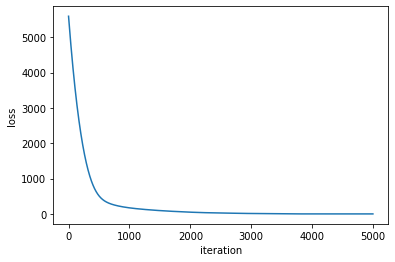

In [11]:
X = torch.from_numpy(users.to_numpy())
U = torch.rand(X.shape[0], 32)
I = torch.rand(X.shape[1], 32)
I.requires_grad = True
U.requires_grad = True

Y = torch.from_numpy(movies) 
V = torch.rand(Y.shape[0], 32)
G = torch.rand(Y.shape[1], 32)
G.requires_grad = True
V.requires_grad = True


LR = 0.001
iteration = 5000
l=[]

optimizer = torch.optim.Adam([U,V,I,G], lr=LR ,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)

for t in range(iteration):

    X_pred = U.mm(I.t())
    Y_pred = V.mm(G.t())

    loss = (X - X_pred).pow(2).sum().sqrt()+ (Y - Y_pred).pow(2).sum().sqrt()
    l.append(loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    if t%100 == 0:
        print("Iteration: %s/%s, Loss: %d" % (t, iteration, loss.item()))
        
    if t == (iteration - 1):
        print("Final loss : %s" % loss.item())
    
    
    optimizer.step()

plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(range(iteration), l)
plt.show()

In [5]:
class NCF(nn.Module):
    def __init__(self, user_num, item_num, user_wight=None, item_weight=None):
        super(NCF, self).__init__()
        self.user_num = user_num
        self.item_num = item_num
        if user_wight:
          self.U = nn.Embedding(user_num, 32, padding_idx=-1,_weight=torch.from_numpy(user_wight).float())
          self.V = nn.Embedding(item_num, 32, padding_idx=-1,_weight=torch.from_numpy(item_weight).float())
        else:
          self.U = nn.Embedding(user_num, 32, padding_idx=-1)
          self.V = nn.Embedding(item_num, 32, padding_idx=-1)
        self.L1 = nn.Linear(32 * 2, 32 * 2, bias=True)
        self.L2 = nn.Linear(32 * 2, 5, bias=True)
        self.dropout = nn.Dropout(0.2)
        #self.activate1 = nn.ReLU(inplace=True)
        nn.init.xavier_normal(self.L1.weight)
        nn.init.xavier_normal(self.L2.weight)  


    def forward(self, u, v):
        #print(max(v))
        u = self.U(u)
        v = self.V(v)
        logits = self.L1(torch.cat([u,v],axis=-1))
        logits = self.dropout(logits)
        logits = F.relu(logits)
        logits = self.L2(logits)  
        logits = logits.reshape(-1,5)
        #print(logits.shape)
        return logits
    

In [181]:
class RatingDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
  
    def __getitem__(self, idx):
        return self.x[idx][0]-1, movie_dic[self.x[idx][1]], self.y[idx]-1
    

In [182]:
def train(model, train_loader, optimizer,  criterion, device, batch_size):
    model.train()
    l = []
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        user, item, y = batch
        #print(max(user))
        user = user.reshape(-1, 1).long()
        item = item.reshape(-1, 1).long()
        y = y.long()
        #user = user.to(device)
        #item = item.to(device)
        #y = y.to(device)

        logits = model(user, item)
        loss = criterion(logits, y)
        l.append(loss.item())
            
      
        loss.backward()
        optimizer.step()
    
    return np.mean(l)


def data_loader(x_train, y_train, x_val, y_val, batch_size):
    dataset_train = RatingDataset(x_train, y_train)
    dataset_val = RatingDataset(x_val, y_val)
    return DataLoader(dataset_train, batch_size=batch_size, shuffle=False, drop_last=False), DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=False)

In [187]:
def evaluation(model, val_loader, batch_size):
  preds = []
  probs = []
  y_list=[]
  for i,(user, item, y) in enumerate(val_loader): 
      user = user.reshape(-1, 1).long()
      item = item.reshape(-1, 1).long()
      y_list.append(y.numpy())
      with torch.no_grad():
        outputs = model(user, item)
        probabilities = F.softmax(outputs, dim=1)
        _, pred = torch.max(probabilities, dim=1)
        probs.append(probabilities.tolist())
        preds.append(pred)
  return np.concatenate(preds,axis=0), np.concatenate(probs,axis=0), np.array([i for i in np.concatenate(y_list,axis=0)])
      

In [6]:
NCF(6040, 3883)

NCF(
  (U): Embedding(6040, 32, padding_idx=6039)
  (V): Embedding(3883, 32, padding_idx=3882)
  (L1): Linear(in_features=64, out_features=64, bias=True)
  (L2): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [183]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()#.to(device)
model = NCF(6040, 3883, U.detach().numpy(), V.detach().numpy())#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
batch_size = 256

In [184]:
#train for NCF++
train_loader, val_loader = data_loader(x_train.values, y_train.values, x_val.values, y_val.values, batch_size)
count=0
for e in range(100):
  loss = train(model, train_loader, optimizer, criterion, device, batch_size)
  if e==0:
    last=loss
  else:
    pre=loss
    if (last-pre)/last <=0.01:
      count+=1
    if count==5:
      print("Final loss: %1.5f" % (loss))
      break
  if e % 5 == 0:
      print("Epoch: %d, loss: %1.5f" % (e, loss)) 

Epoch: 0, loss: 1.27586
Epoch: 5, loss: 1.23613
Epoch: 10, loss: 1.23536
Epoch: 15, loss: 1.23522
Epoch: 20, loss: 1.23547
Epoch: 25, loss: 1.23530
Epoch: 30, loss: 1.23506
Epoch: 35, loss: 1.23518
Epoch: 40, loss: 1.23511
Epoch: 45, loss: 1.23528
Epoch: 50, loss: 1.23491
Epoch: 55, loss: 1.23520
Epoch: 60, loss: 1.23506
Epoch: 65, loss: 1.23499
Epoch: 70, loss: 1.23519
Epoch: 75, loss: 1.23508
Epoch: 80, loss: 1.23511
Epoch: 85, loss: 1.23497
Epoch: 90, loss: 1.23504
Epoch: 95, loss: 1.23508


In [188]:
preds, probs, y_true = evaluation(model, val_loader, batch_size)

              precision    recall  f1-score   support

           0       0.50      0.21      0.30      4496
           1       0.36      0.07      0.11      8580
           2       0.40      0.41      0.41     20984
           3       0.45      0.64      0.53     27921
           4       0.53      0.45      0.49     18039

    accuracy                           0.45     80020
   macro avg       0.45      0.36      0.37     80020
weighted avg       0.45      0.45      0.43     80020



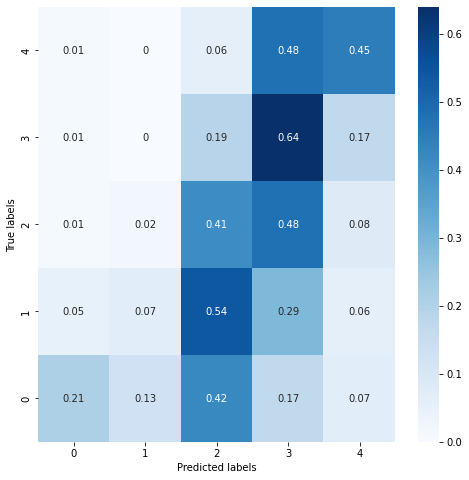

In [194]:
# results for NCF++
import seaborn as sns
acc = accuracy_score(y_true, preds)
classification_report(y_true, preds)
 
 #peint calssification report
print(classification_report(y_true, preds))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, preds, labels=range(5))
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 5)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [205]:
#train for traditional CF with nerual network
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()#.to(device)
model = NCF(6040, 3883, None, None)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
batch_size = 256
train_loader, val_loader = data_loader(x_train.values, y_train.values, x_val.values, y_val.values, batch_size)
count=0
for e in range(100):
  loss = train(model, train_loader, optimizer, criterion, device, batch_size)
  if e==0:
    last=loss
  else:
    pre=loss
    if (last-pre)/last <=0.01:
      count+=1
    if count==5:
      print("Final loss: %1.5f" % (loss))
      break
  if e % 5 == 0:
      print("Epoch: %d, loss: %1.5f" % (e, loss)) 

Epoch: 0, loss: 1.43631
Epoch: 5, loss: 1.23863
Epoch: 10, loss: 1.23652
Epoch: 15, loss: 1.23506
Epoch: 20, loss: 1.23522
Epoch: 25, loss: 1.23532
Epoch: 30, loss: 1.23513
Epoch: 35, loss: 1.23527
Epoch: 40, loss: 1.23504
Epoch: 45, loss: 1.23514
Epoch: 50, loss: 1.23518
Epoch: 55, loss: 1.23503
Epoch: 60, loss: 1.23504
Epoch: 65, loss: 1.23499
Epoch: 70, loss: 1.23525
Epoch: 75, loss: 1.23521
Epoch: 80, loss: 1.23525
Epoch: 85, loss: 1.23508
Epoch: 90, loss: 1.23496
Epoch: 95, loss: 1.23527


              precision    recall  f1-score   support

           0       0.49      0.21      0.30      4496
           1       0.35      0.07      0.11      8580
           2       0.40      0.41      0.41     20984
           3       0.45      0.64      0.53     27921
           4       0.53      0.45      0.49     18039

    accuracy                           0.45     80020
   macro avg       0.45      0.36      0.37     80020
weighted avg       0.45      0.45      0.43     80020



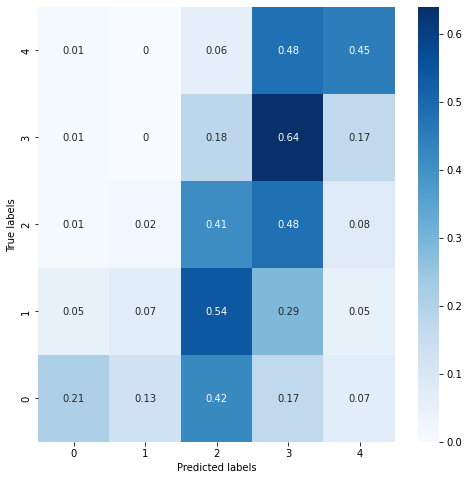

In [206]:
# results for traditional NCF
import seaborn as sns

preds, probs, y_true = evaluation(model, val_loader, batch_size)
acc = accuracy_score(y_true, preds)
classification_report(y_true, preds)
 
 #peint calssification report
print(classification_report(y_true, preds))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, preds, labels=range(5))
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 5)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**Generating Results for testset**

In [195]:
rating_test.head()

,UserID,MovieID,timestamps
0,1,914,978301968
1,1,2018,978301777
2,1,2797,978302039
3,1,1270,978300055
4,1,1545,978824139


In [197]:
user = np.array([i-1 for i in rating_test['UserID'].values])
item = np.array([movie_dic[i] for i in rating_test['MovieID'].values])

user = torch.tensor(user).reshape(-1,1).long()
item = torch.tensor(item).reshape(-1,1).long()
preds=[]
with torch.no_grad():
    outputs = model(user, item)
    _, pred = torch.max(F.softmax(outputs, dim=1), dim=1)
    preds.append(pred)
preds = np.concatenate(preds,axis=0)

In [201]:
preds = np.array([i+1 for i in preds])
rating_test['Rating'] = preds

In [203]:
rating_test.drop(['timestamps'], axis=1, inplace=True)
rating_test.to_csv('Q5_output.csv')

In [ ]:
def test():
  #dataset_test = RatingDataset(rating_test['UserID'].values, rating_test['MovieID'].values)
  #test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)
  for i,(user, item, y) in enumerate(test_data): 
      user = user.reshape(-1, 1).long()
      item = item.reshape(-1, 1).long()
      #y_list.append(y.numpy())
      with torch.no_grad():
        outputs = model(user, item)
        probabilities = F.softmax(outputs, dim=1)
        _, pred = torch.max(probabilities, dim=1)
        probs.append(probabilities.tolist())
        preds.append(pred)